In [14]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
import glob
# import cv2

### Cargar Imagenes

In [16]:
ENTRENAMIENTO_DIR = "/Users/cdiaz19/Desktop/archive/simpsons1/*.png"
image_paths = glob.glob(ENTRENAMIENTO_DIR)
len(image_paths)

200

In [17]:
def load_preprosess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.cast(img, tf.float32)
    img = img / 255
    img = img * 2 - 1
    img = img.numpy()    
    return img

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1) 
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.axis("off")

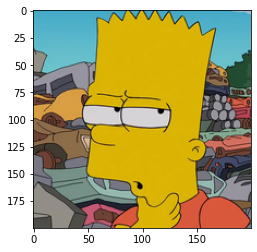

In [18]:
plt.imshow((load_preprosess_image(image_paths[1])+1)/2)

In [19]:
images = [load_preprosess_image(path) for path in image_paths]
images = np.array(images).astype(np.float32)
images.shape

(200, 200, 200, 3)

In [10]:
batch_size = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE
Shuffle_parameter = len(image_paths) // 2

# crear tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.shuffle(Shuffle_parameter).batch(batch_size,drop_remainder=True).prefetch(AUTOTUNE)

InvalidArgumentError: buffer_size must be greater than zero. [Op:ShuffleDatasetV3]

In [70]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(8 * 8 * 256, input_shape=[codings_size]),
    keras.layers.Reshape([8, 8, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
     keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

generator.summary()

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[64, 64, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16384)             1654784   
_________________________________________________________________
reshape_6 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 8, 8, 128)         819328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 16, 16, 64)        204864    
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 16, 64)      

In [11]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=100):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))             
        for X_batch in dataset:
            # fase 1 - entrenar el discriminador
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # fase 2 - entrenar el generador.
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                    
        plt.show()                                                   

In [12]:
train_gan(gan, dataset, batch_size, codings_size)

NameError: name 'gan' is not defined

(-0.5, 63.5, 63.5, -0.5)

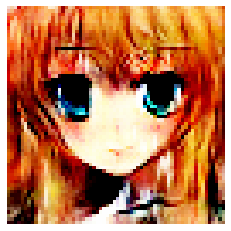

In [88]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)

image = np.clip(generated_images[17], 0, 1)
plt.imshow(image)
plt.axis("off")